In [1]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import time
#from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm
import time

In [94]:
gsparams = galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=1.e-5)
pixel_scale = 0.1 #as/px
lamda = 550 #nm
diameter = 1.2 #m
psf_oversample = 5.
gal_oversample = 1.
interpolant = 'lanczos200'
# Make epsf, draw epsf image, interpolated image
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)
given_psf = psf.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel') #Draw oversampled psf image
psf_galsample = psf.drawImage(scale=pixel_scale/gal_oversample,method='no_pixel') #Draw at galaxy scale for shape measurement
psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams,x_interpolant=interpolant)


In [95]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
sersicfit = cc.param_cat['sersicfit']
hlr, sn, q, phi = [sersicfit[:,i] for i in (1,2,3,7)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][400:405] #Large galaxies, reasonable sersic n
gals = sm.makeGalaxy(cc,small100I, chromatic=False, gsparams=gsparams,trunc_factor=0.0)
intrinsicAngles = phi[small100I]
thetas = [0]
rotGalVec = np.vectorize(sm.rotGal)
rotGals = np.stack([rotGalVec(gals,intrinsicAngles,targetTheta) for targetTheta in thetas]) #(nrot, ngals)

def gete(q,b):
    shear = galsim.shear.Shear(q=q, beta=b*galsim.radians)
    return np.array([shear.e1, shear.e2])
q0 = q[small100I]
QQ, THTH = np.meshgrid(q0, thetas)
shearVec = np.vectorize(gete, otypes=[object])
trueShears = shearVec(QQ, THTH)
trueShears = np.stack([np.stack(x) for x in trueShears]) #(nrot, ngals, (e1, e2))

In [96]:
i=2
gal=rotGals[0,i]
trueEll = np.array(trueShears[0,i])
print trueEll

[0.26438861 0.        ]


# Timing Comparison

In [14]:
%timeit res=sm.measureShapeReconv(gal,psf,psf_galsample,pixel_scale/gal_oversample, psfii, gsparams, interpolant) #both lanczos7

10 loops, best of 3: 38.5 ms per loop


In [9]:
%timeit res=sm.measureShapeReconv(gal,psf,psf_galsample,pixel_scale/gal_oversample, psfii, gsparams) #both sinc

1 loop, best of 3: 29.2 s per loop


In [5]:
%timeit res=sm.measureShapeReconv(gal,psf,psf_galsample,pixel_scale/gal_oversample, psfii, gsparams) #gal sinc

1 loop, best of 3: 29.1 s per loop


In [19]:
%timeit res=sm.measureShapeReconv(gal,psf,psf_galsample,pixel_scale/gal_oversample, psfii, gsparams) #psf sinc

1 loop, best of 3: 1.62 s per loop


In [23]:
%timeit res=sm.measureShapeReconv(gal,psf,psf_galsample,pixel_scale/gal_oversample, psfii, gsparams) #no sinc

10 loops, best of 3: 39.7 ms per loop


# Performance Comparison

In [97]:
st = time.time()
orig = sm.galShiftErrs(gal, psf, 5, pixel_scale/gal_oversample)
orig_time = np.round(time.time()-st,1)
print 'orig time: ', orig_time
st = time.time()
reconv = sm.galShiftErrs(gal,psf, 5 , pixel_scale/gal_oversample, sm.measureShapeReconv, psfii, interpolant, gsparams)
reconv_time = np.round(time.time()-st,1)
print 'reconv time: ', reconv_time


orig time:  0.4
reconv time:  2.8


In [98]:
def meanstd(tup):
    m = np.array([np.nanmean(tup[0]), np.nanmean(tup[1])])
    s = np.array([np.nanstd(tup[0]), np.nanstd(tup[1])])
    return m,s

reconvMean, reconvStd = meanstd(reconv)
origMean, origStd = meanstd(orig)
diffMean, diffStd = meanstd((np.array(reconv[0])-np.array(orig[0]), np.array(reconv[1])-np.array(orig[1])))
odiff = origMean - trueEll
rdiff = reconvMean - trueEll

lanczos200. orig time: 0.4s reconv time: 2.8s
orig err  [ 3.07222139e-02 -9.82487472e-07] [6.59360861e-03 1.36701211e-06]
reconv err  [ 3.07215571e-02 -9.93321969e-07] [6.59308230e-03 1.36868497e-06]
diff err  [-6.56843185e-07 -1.08344968e-08] [5.34017702e-07 1.46389047e-08]


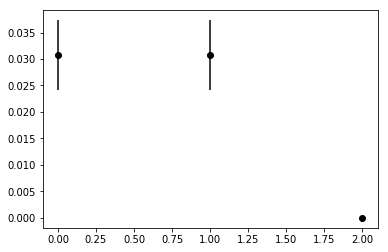

In [99]:
print 'lanczos200. orig time: %ss reconv time: %ss' % (orig_time, reconv_time)
print 'orig err ', odiff, origStd
print 'reconv err ', rdiff, reconvStd
print 'diff err ', diffMean, diffStd
i = 0
plt.errorbar([0,1,2], [odiff[i], rdiff[i], diffMean[i]], fmt='o',c='k',yerr=[origStd[i], reconvStd[i], diffStd[i]])
plt.show()

lanczos100. orig time: 0.4s reconv time: 1.2s
orig err  [ 3.07222139e-02 -9.82487472e-07] [6.59360861e-03 1.36701211e-06]
reconv err  [ 3.07209014e-02 -1.01921296e-06] [6.59256618e-03 1.36629979e-06]
diff err  [-1.31249428e-06 -3.67254925e-08] [1.05644857e-06 3.60918589e-08]


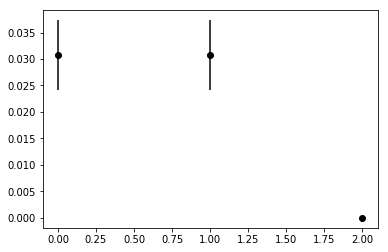

In [93]:
print 'lanczos100. orig time: %ss reconv time: %ss' % (orig_time, reconv_time)
print 'orig err ', odiff, origStd
print 'reconv err ', rdiff, reconvStd
print 'diff err ', diffMean, diffStd
i = 0
plt.errorbar([0,1,2], [odiff[i], rdiff[i], diffMean[i]], fmt='o',c='k',yerr=[origStd[i], reconvStd[i], diffStd[i]])
plt.show()

lanczos10. orig time: 0.4s reconv time: 0.8s
orig err  [ 3.07222139e-02 -9.82487472e-07] [6.59360861e-03 1.36701211e-06]
reconv err  [ 3.06415295e-02 -1.62012237e-06] [6.53676993e-03 1.46891792e-06]
diff err  [-8.06844234e-05 -6.37634901e-07] [5.75574219e-05 4.88610209e-07]


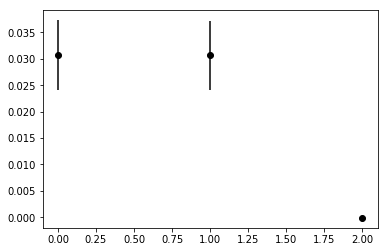

In [86]:
print 'lanczos10. orig time: %ss reconv time: %ss' % (orig_time, reconv_time)
print 'orig err ', odiff, origStd
print 'reconv err ', rdiff, reconvStd
print 'diff err ', diffMean, diffStd
i = 0
plt.errorbar([0,1,2], [odiff[i], rdiff[i], diffMean[i]], fmt='o',c='k',yerr=[origStd[i], reconvStd[i], diffStd[i]])
plt.show()

Both lanczos7. orig time: 0.4s reconv time: 0.7s
orig err  [ 3.07222139e-02 -9.82487472e-07] [6.59360861e-03 1.36701211e-06]
reconv err  [ 3.04666495e-02 -1.66452782e-06] [6.49550887e-03 1.48583422e-06]
diff err  [-2.55564451e-04 -6.82040346e-07] [9.93778551e-05 5.24147573e-07]


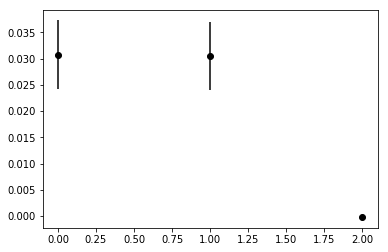

In [80]:
print 'Both lanczos7. orig time: %ss reconv time: %ss' % (orig_time, reconv_time)
print 'orig err ', odiff, origStd
print 'reconv err ', rdiff, reconvStd
print 'diff err ', diffMean, diffStd
i = 0
plt.errorbar([0,1,2], [odiff[i], rdiff[i], diffMean[i]], fmt='o',c='k',yerr=[origStd[i], reconvStd[i], diffStd[i]])
plt.show()

sinc orig time: 0.4s reconv time: 715.7s
orig err  [ 3.07222139e-02 -9.82487472e-07] [6.59360861e-03 1.36701211e-06]
reconv err  [ 3.07219910e-02 -9.83033005e-07] [6.59343412e-03 1.36770918e-06]
diff err  [-2.22921371e-07 -5.45533099e-10] [1.77441736e-07 4.50254817e-09]


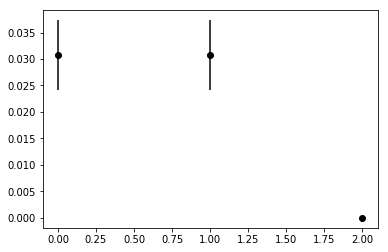

In [74]:
print 'sinc orig time: %ss reconv time: %ss' % (orig_time, reconv_time)
print 'orig err ', odiff, origStd
print 'reconv err ', rdiff, reconvStd
print 'diff err ', diffMean, diffStd
i = 0
plt.errorbar([0,1,2], [odiff[i], rdiff[i], diffMean[i]], fmt='o',c='k',yerr=[origStd[i], reconvStd[i], diffStd[i]])
plt.show()

quintic. orig time: 0.4s reconv time: 0.7s
orig err  [ 3.07222139e-02 -9.82487472e-07] [6.59360861e-03 1.36701211e-06]
reconv err  [ 2.24830925e-02 -1.65377253e-06] [5.65973440e-03 1.42977092e-06]
diff err  [-8.23912144e-03 -6.71285053e-07] [9.42841007e-04 5.65661243e-07]


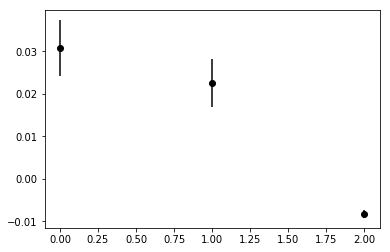

In [64]:
print 'quintic. orig time: %ss reconv time: %ss' % (orig_time, reconv_time)
print 'orig err ', odiff, origStd
print 'reconv err ', rdiff, reconvStd
print 'diff err ', diffMean, diffStd
i = 0
plt.errorbar([0,1,2], [odiff[i], rdiff[i], diffMean[i]], fmt='o',c='k',yerr=[origStd[i], reconvStd[i], diffStd[i]])
plt.show()

In [14]:
gal.original.half_light_radius

0.1776697330380235

In [19]:
q0[2]

0.762753018521753